In [1]:
from typing import Literal
from typing_extensions import TypedDict, List
import os 

# 서드파티 라이브러리
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, START, END
from pyzerox import zerox

# LangChain 관련 라이브러리
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import (
    PyPDFLoader,
    UnstructuredMarkdownLoader,
    TextLoader,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain_groq import ChatGroq
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
import markdown
from bs4 import BeautifulSoup
from datetime import date
from pydantic import BaseModel, Field

load_dotenv()

True

In [17]:
MODEL_NAME = "gemma2-9b-it"

llm = ChatGroq(model_name=MODEL_NAME)
small_llm = ChatGroq(model_name=MODEL_NAME)
router_llm = ChatGroq(model_name=MODEL_NAME)

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

In [18]:
class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""


# 간단한 테스크 -> 저렴한 모델 사용해도 무방 

structured_router_llm = router_llm.with_structured_output(Route)


router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])
def router(state: AgentState) -> Literal['income_tax', 'real_estate_tax', 'llm']:
    query = state["query"]
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({"query": query})
    print(f"route == {route}")
    print(f"route.target == {route.target}")
    return route.target

In [25]:
def call_llm(state: AgentState) -> AgentState:
    query = state["query"]
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)

    return {"answer" : llm_answer}



In [20]:
from income_tax_graph import graph as income_tax_agent
from real_estate_graph import graph as real_estate_tax_agent


In [26]:
graph_builder = StateGraph(AgentState)



graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

graph_builder.add_conditional_edges(
    START,
    router,
    {
        "income_tax" : "income_tax",
        "real_estate_tax" : "real_estate_tax",
        "llm" : "llm"
        
    })

graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

graph = graph_builder.compile()



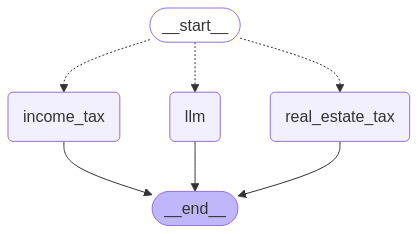

In [27]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)


In [28]:
initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

route == target='llm'
route.target == llm


{'query': '떡볶이는 어디가 맛있나요?',
 'answer': '떡볶이 맛집은 너무나 많아서 딱 하나를 추천하기는 어렵네요! \n\n어떤 떡볶이 스타일을 좋아하시나요? \n\n* **진짜 떡볶이 맛:** 쫄깃한 떡과 매콤달콤한 양념, 그리고 어묵! 순수한 떡볶이 맛을 원한다면, **매운 맛이 강한 골목 떡볶이**를 추천해요. \n* **개성 넘치는 떡볶이:** 퓨전 떡볶이, 떡볶이 라면, 치즈 떡볶이 등 다양한 변형을 즐기고 싶다면, ** trendy 트렌디 떡볶이집**을 찾아보세요! \n\n혹시 지역이나 특별히 원하는 떡볶이 종류를 말씀해주시면 더 자세히 추천해드릴 수 있어요! 😊\n'}

In [30]:
initial_state = {'query': '집 25억은 세금 얼마냐'}
graph.invoke(initial_state)

route == target='real_estate_tax'
route.target == real_estate_tax


{'query': '집 25억은 세금 얼마냐',
 'answer': '죄송합니다만, 제가 제공하는 정보만으로는 사용자 주택의 세금을 계산해 드릴 수 없습니다. \n\n주택 세금 계산에는 주택 종류, 면적, 소재지, 공시가격, 공정시장가액비율, 공제 가능 금액 등 다양한 정보가 필요합니다. \n\n특히, 2025년 공시가격에 적용될 공정시장가액비율은 현재 확정되지 않았습니다. 관련 기관의 공식 발표를 기다려야 합니다. \n\n위 정보가 확정되면 주택 종류, 면적, 소재지 등을 알려주시면 주택 세금을 계산해드릴 수 있습니다. \n\n\n'}

In [31]:
initial_state = {'query': '집 1억은 세금 얼마냐'}
graph.invoke(initial_state)

route == target='real_estate_tax'
route.target == real_estate_tax


{'query': '집 1억은 세금 얼마냐',
 'answer': '주택의 공시가격이 1억 원이라고 하셨고, 2025년 3월 11일 기준으로 공정시장가액비율을 60%로 가정했을 때 과세표준은 6,000만 원입니다. \n\n**다만, 정확한 과세표준을 계산하기 위해서는 2025년 3월 11일 기준의 공정시장가액비율을 확인해야 합니다.** \n\n\n공정시장가액비율은 변동될 수 있으며, 제공된 정보만으로는 정확하게 알 수 없습니다.  \n\n**종합부동산세는 과세표준에 따라 계산되며, 아래와 같은 세율을 적용합니다.** \n\n* **1억 원 초과** 5,206만원 + (1억5천만원 초과액 × 48%) \n\n따라서 공정시장가액비율 및 2025년 세율을 기반으로 계산하면 정확한 종합부동산세를 알 수 있습니다. \n\n\n\n'}